In [1]:
# nEpochs=20  # orig, longer training
nEpochs=3  # quick testing during development

# Select one (and only one) model to train
USE_CGAN = False
USE_CVAE = True
USE_CVAECGAN = False

# Extract model name based on boolean value above
model_name = ""
if USE_CGAN:
    model_name += "cgan"
elif USE_CVAE:
    model_name += "cvae"
elif USE_CVAECGAN:
    model_name += "cvaecgan"

# Double check model name is valid
if model_name not in {"cgan", "cvae", "cvaecgan"}:
    raise Exception("Double check you are only using one model. The current model name is invalid")

## 1. Import 3rd party libraries 

In [2]:
import os
import session_info
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

try:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    gpus = tf.config.list_physical_devices("GPU")
    print(gpus)
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3300)]
    )
except:
    Warning("Unable To configure Tensorflow GPU")
    
# Import our own classes 
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional, SaveImagesConditional
from vaegan.gan_SOLUTIONS import ConditionalGAN
from vaegan.vae_SOLUTIONS import ConditionalVAE
from vaegan.conditional.models import ConditionalVAECGAN

#session_info.show()

2025-05-30 09:28:01.718026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748615281.740661   39133 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748615281.747652   39133 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748615281.765403   39133 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748615281.765420   39133 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748615281.765422   39133 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Show some our data

I0000 00:00:1748615286.037166   39133 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3300 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0


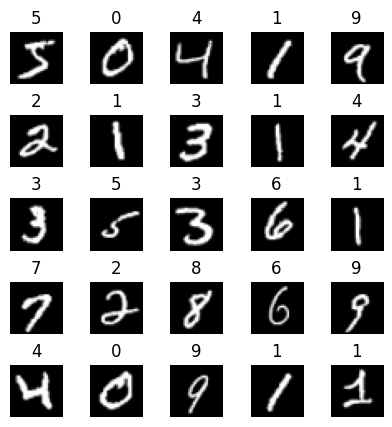

In [3]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist' + f"_hpo_{model_name}"
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [4]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
hpo_params = {
    'n_latent_dims' : 4,
    'learning_rate': 0.001,
    'encoder_params' : {
        'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4,4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'decoder_params' : {'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'generator_params' : {
        'generator_conv_layer_units' : [128,128],
        'generator_conv_layer_kernel_size' : [4,4],
        'generator_conv_layer_strides' : [(2,2), (2,2)],
        'generator_conv_layer_activation_functions' : [tf.nn.leaky_relu,tf.nn.leaky_relu],
        'discriminator_dense_layer_units' : [128],
        'generator_dense_layer_units' : [],
    },
    'discriminator_params' : {
        'discriminator_conv_layer_units' : [32,64],
        'discriminator_conv_layer_kernel_size' : [4,4],
        'discriminator_conv_layer_strides' : [(1,1), (2,2)],
        'discriminator_conv_layer_activation_functions' : ['relu','relu'],
        'discriminator_dense_layer_units' : [],
        'generator_dense_layer_units' : [],
    }
}

if USE_CGAN:
    model = ConditionalGAN(n_classes=n_classes,
                                 n_latent_dims = hpo_params['n_latent_dims'],
                                 generator_params = hpo_params['generator_params'],
                                 discriminator_params = hpo_params['discriminator_params'])
if USE_CVAE:
    model = ConditionalVAE(n_classes=n_classes, 
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params = hpo_params['encoder_params'],
                            decoder_params = hpo_params['decoder_params'],
    )
if USE_CVAECGAN:
    model = ConditionalVAECGAN(adv_loss_weight=10., 
                            n_classes=n_classes,
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params=hpo_params['encoder_params'],
                            decoder_params=hpo_params['decoder_params'],
                            discriminator_params=hpo_params['discriminator_params']
    )


# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.

# All three models will use this input structure
model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
if USE_CVAE or USE_CVAECGAN:
    model.decoder.compute_output_shape((None, n_classes + model.n_latent_dims))
if USE_CGAN or USE_CVAECGAN:
    model.discriminator.compute_output_shape((None, 32, 32, 1))

Loaded version: vaegan.vae_SOLUTIONS
Loaded version: vaegan.vae_SOLUTIONS


In [5]:
print("=== OVERALL MODEL ====")
model.summary()

if USE_CGAN:
    print("=== GENERATOR SUBMODEL ====")
    gen_in = tf.keras.layers.Input(model.n_latent_dims+model.n_classes)
    gen_out  = model.generator.call(gen_in) 
    gen = tf.keras.Model(gen_in, gen_out) 
    gen.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(model.image_shape) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()
if USE_CVAE:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input(model.n_latent_dims+model.n_classes) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
if USE_CVAECGAN:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input(model.n_latent_dims + model.n_classes) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(model.image_shape) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()


=== OVERALL MODEL ====
Model: "cvae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2117912   
                                                                 
 decoder (Decoder)           (None, 32, 32, 1)         328097    
                                                                 
Total params: 2446015 (9.33 MB)
Trainable params: 2445689 (9.33 MB)
Non-trainable params: 326 (1.27 KB)
_________________________________________________________________
=== ENCODER SUBMODEL ====
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 11)]         0         []                            
                                                           

In [6]:
_ = model([data.images_train[:1], labels_onehot[:1]])

I0000 00:00:1748615304.439835   39133 cuda_dnn.cc:529] Loaded cuDNN version 90300


## 6. Compile the model 

In [7]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=hpo_params['learning_rate']))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
if USE_CGAN:
    save_images_callback = GenerateImagesConditional(output_dir=output_dir, 
                                                    model=model,
                                                    example_labels=labels_onehot[:10],
                                                    n_generated_images=10,
                                                    n_latent_dims=model.n_latent_dims)
elif USE_CVAE or USE_CVAECGAN:
    save_images_callback = SaveImagesConditional(output_dir=output_dir, 
                                                model=model,
                                                example_images=data.images_train[:10],
                                                example_labels=labels_onehot[:10],
                                                n_generated_images=10,
                                                n_latent_dims=model.n_latent_dims)



/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/tf_keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## 7. Train (fit) the model on the data 

In [8]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

Epoch 1/3
469/469 [==============================] - 13s 22ms/step - recon_loss: 50.6209 - kl_loss: 25.9040 - total_loss: 76.5250
Epoch 2/3
469/469 [==============================] - 10s 21ms/step - recon_loss: 33.8210 - kl_loss: 6.5303 - total_loss: 40.3513
Epoch 3/3
469/469 [==============================] - 10s 22ms/step - recon_loss: 30.0797 - kl_loss: 6.0192 - total_loss: 36.0990


In [12]:
logs.history

{'recon_loss': [50.62092971801758, 33.82101058959961, 30.07974624633789],
 'kl_loss': [25.904041290283203, 6.530307292938232, 6.019240856170654],
 'total_loss': [76.52500915527344, 40.351322174072266, 36.09899139404297]}

## 8. Training saves results to disk, now also plot training curves

INFO:tensorflow:Assets written to: ./outputs/mnist_hpo_cvae/cvae/assets


INFO:tensorflow:Assets written to: ./outputs/mnist_hpo_cvae/cvae/assets


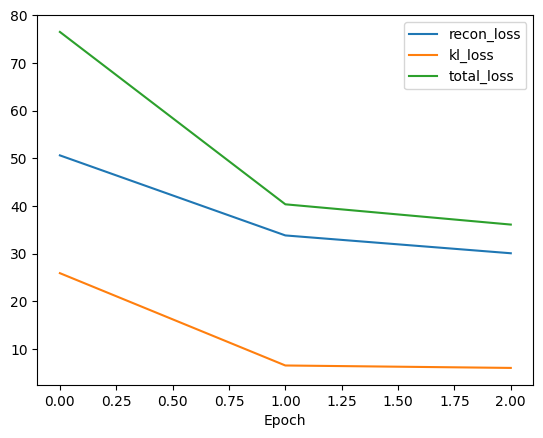

In [13]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['recon_loss', 'kl_loss', 'total_loss']:
    if loss_name in logs.history.keys():
        loss_values = logs.history[loss_name]
        x = np.arange(len(loss_values))
        ax.plot(x, loss_values, label=loss_name)
        
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
# fig.show()

# Save the model 
model.save(os.path.join(output_dir, model_name))


# HPO Exercise: Your Turn!
- Take the code from above, and implement a grid search over at least 2 hyper parameters (try at least 3 different values for each hyper parameter)
  - Train each model for at least 20 epochs. 
  - You can modify both hyperparameters at the same time, or perform two completely separate sequential tunings. 
  - You can find some suggested hyperparameter ranges / values in the table below:

Hyperparameter | [min value, max value]
----------------|-----------------------
Number of latent dims: |   [2, 128]
Number of Convolutional layers: |     [1, 6]
Number of convolutional layer units:|     [4, 256]
Convolutional kernel size: | [2, 5]
Convolutional layer activation functions (choose): |  ['relu', 'elu', 'linear', tf.nn.leaky_relu, 'softmax', 'sigmoid']
Dense layer units: | [4, 256]
Learning Rate:  | [0.01, 0.000001]


In [11]:
## !!!!IMPORTANT!!!!
## Keep the seed the same across ALL HPO experiments. Be sure to reinitialize for EVERY new model.
tf.random.set_seed(1234)
## !!!!IMPORTANT!!!!


# Instantiate a container with the hyperparameter(s) you want to test


# Instantiate a model for a hyperparameter (combination)
## Note: I would recommend naming your model with the specific HPO you are trying at the moment.

# Build a model with input / output dimensions

# Compile the model

# Fit model to the data

# Plot the training curves for the model

# Save the model 

# Assuming you are using the provided callbacks and save the model/outputs appropriately,
# You should be able to use the provided `image_viewer` to look at the fakes and/or recons just by
# Passing in a model's name/directory.


In [14]:
nEpochs=20

In [17]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
history_per_lr = {}

for lr in learning_rates:
    print(f"\n=== Training ConditionalVAE with learning rate: {lr} ===")
    
    # Update learning rate in hpo_params
    hpo_params['learning_rate'] = lr

    # Create model
    model = ConditionalVAE(
        n_classes=n_classes,
        n_latent_dims=hpo_params['n_latent_dims'],
        encoder_params=hpo_params['encoder_params'],
        decoder_params=hpo_params['decoder_params']
    )

    # Compile with current learning rate
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=hpo_params['learning_rate']))
    
    # Fit the model
    history = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])
    
    # Save history
    history_per_lr[lr] = history.history



=== Training ConditionalVAE with learning rate: 0.01 ===
Loaded version: vaegan.vae_SOLUTIONS
Loaded version: vaegan.vae_SOLUTIONS
Epoch 1/20
  4/469 [..............................] - ETA: 9s - recon_loss: 311.5816 - kl_loss: 62927.0430 - total_loss: 63238.6250WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0092s vs `on_train_batch_end` time: 0.0099s). Check your callbacks.


469/469 [==============================] - 11s 21ms/step - recon_loss: 64.4132 - kl_loss: 5996697092096.0000 - total_loss: 5996697092096.0000
Epoch 2/20
469/469 [==============================] - 10s 22ms/step - recon_loss: 50.3138 - kl_loss: 6236.1768 - total_loss: 6286.4927
Epoch 3/20
469/469 [==============================] - 10s 22ms/step - recon_loss: 49.6457 - kl_loss: 10476.6895 - total_loss: 10526.3389
Epoch 4/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 49.2355 - kl_loss: 13793.7891 - total_loss: 13843.0264
Epoch 5/20
469/469 [==============================] - 10s 22ms/step - recon_loss: 49.2660 - kl_loss: 13816.5693 - total_loss: 13865.8477
Epoch 6/20
469/469 [==============================] - 10s 22ms/step - recon_loss: 48.9152 - kl_loss: 13486.1631 - total_loss: 13535.0830
Epoch 7/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 49.1089 - kl_loss: 13569.9209 - total_loss: 13619.0371
Epoch 8/20
469/469 [==================

469/469 [==============================] - 11s 21ms/step - recon_loss: 58.4679 - kl_loss: 25.8644 - total_loss: 84.3323
Epoch 2/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 33.5458 - kl_loss: 6.5141 - total_loss: 40.0599
Epoch 3/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 29.2873 - kl_loss: 5.7999 - total_loss: 35.0872
Epoch 4/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 27.1483 - kl_loss: 5.7953 - total_loss: 32.9436
Epoch 5/20
469/469 [==============================] - 12s 25ms/step - recon_loss: 25.6792 - kl_loss: 5.7861 - total_loss: 31.4653
Epoch 6/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 25.0724 - kl_loss: 5.8430 - total_loss: 30.9154
Epoch 7/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 24.6101 - kl_loss: 5.8808 - total_loss: 30.4909
Epoch 8/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 24.2978 - kl_loss:

469/469 [==============================] - 14s 27ms/step - recon_loss: 94.4153 - kl_loss: 5.4989 - total_loss: 99.9142
Epoch 2/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 49.7471 - kl_loss: 5.0199 - total_loss: 54.7670
Epoch 3/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 38.8705 - kl_loss: 5.2104 - total_loss: 44.0809
Epoch 4/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 33.6872 - kl_loss: 5.4796 - total_loss: 39.1668
Epoch 5/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 30.4691 - kl_loss: 5.5881 - total_loss: 36.0572
Epoch 6/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 28.8388 - kl_loss: 5.7122 - total_loss: 34.5510
Epoch 7/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 27.4251 - kl_loss: 5.7695 - total_loss: 33.1946
Epoch 8/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 26.5267 - kl_loss: 

469/469 [==============================] - 11s 21ms/step - recon_loss: 244.3181 - kl_loss: 9.2513 - total_loss: 253.5694
Epoch 2/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 183.4003 - kl_loss: 3.8891 - total_loss: 187.2895
Epoch 3/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 151.5535 - kl_loss: 4.0993 - total_loss: 155.6528
Epoch 4/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 135.8159 - kl_loss: 4.4085 - total_loss: 140.2243
Epoch 5/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 128.6578 - kl_loss: 4.3108 - total_loss: 132.9686
Epoch 6/20
469/469 [==============================] - 14s 31ms/step - recon_loss: 123.9103 - kl_loss: 3.8784 - total_loss: 127.7886
Epoch 7/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 119.6451 - kl_loss: 3.5191 - total_loss: 123.1643
Epoch 8/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 116.8

469/469 [==============================] - 11s 21ms/step - recon_loss: 327.5223 - kl_loss: 15.6614 - total_loss: 343.1837
Epoch 2/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 280.9797 - kl_loss: 17.0904 - total_loss: 298.0700
Epoch 3/20
469/469 [==============================] - 17s 36ms/step - recon_loss: 266.3143 - kl_loss: 14.0683 - total_loss: 280.3826
Epoch 4/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 258.5357 - kl_loss: 11.3286 - total_loss: 269.8643
Epoch 5/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 253.2908 - kl_loss: 9.3069 - total_loss: 262.5977
Epoch 6/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 248.7405 - kl_loss: 7.6076 - total_loss: 256.3480
Epoch 7/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 244.2365 - kl_loss: 6.3790 - total_loss: 250.6154
Epoch 8/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 2

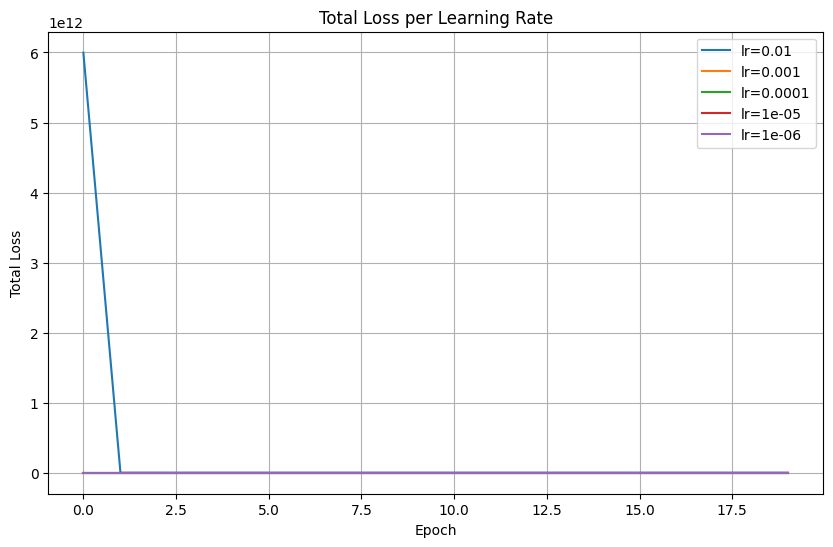

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for lr, logs in history_per_lr.items():
    plt.plot(logs['total_loss'], label=f"lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Total Loss per Learning Rate")
plt.legend()
plt.grid(True)
plt.show()

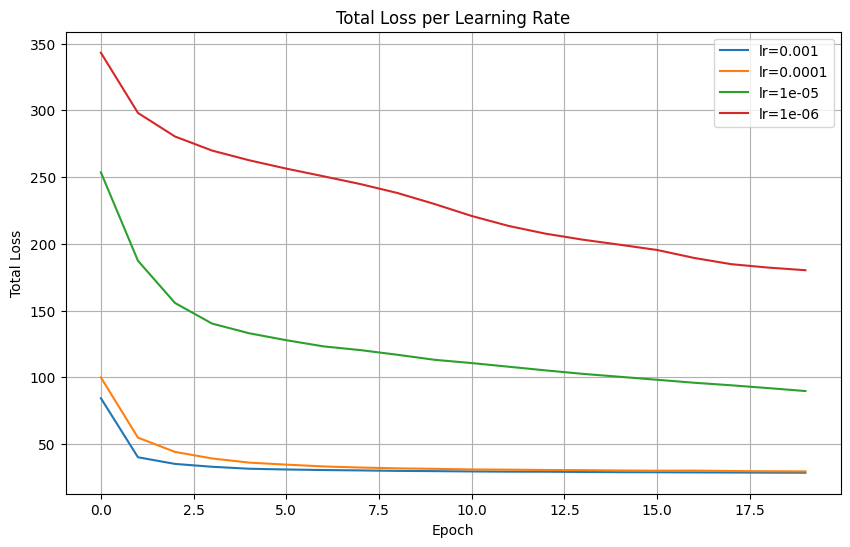

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for lr, logs in list(history_per_lr.items())[1:]:
    plt.plot(logs['total_loss'], label=f"lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Total Loss per Learning Rate")
plt.legend()
plt.grid(True)
plt.show()